<span style="color:green">Welcome to Jake's Python Data Exploration: Stock Market and Inflation</span> 

In 2022, inflation had an abnormal impact on the stock market performance as the Fed continued to raise interest rates. This exploration aims to investigate the correlation between inflation-related economic factors and the stock market during a rising rate environment. By examining historical data, we can gain insight into potential future market trends. Since 1990, there have been four rate hiking cycles, each lasting an average of 18 months: June 1999 to June 2000, June 2004 to June 2006, December 2015 to December 2018, and March 2022 to the present. (To find out more about how I derived these time periods and the relationship between the stock market and interest rates, please check out my Tableau Data Exploration: https://public.tableau.com/views/Capstone1_16607092350810/Story1?:language=en-US&:display_count=n&:origin=viz_share_link).

I will be focusing on the relationship between the stock market (S&P 500) and the following economic variables:

**Core CPI** - Core CPI is a measurement of inflation excluding more volatile categories, food, and energy. As the Fed looks primarily at 'core' prices, a rise in core CPI seems to have negatively impacted the stock market, as it can lead to the Fed increasing rates.

**WTI Crude Oil** - Oil prices have skyrocketed in 2022 mainly due to the Russia-Ukraine war that impacted oil supplies. A rise in oil prices seems to negatively impact the stock market as it leads to a rise in inflation and the Fed increasing rates.

**Unemployment** - Rising unemployment rates can indicate a weak economy, which usually negatively impacts the stock market. However, towards the end of 2022, most investors were hoping for higher unemployment in the hopes that the Fed would slow down or stop raising interest rates with a rise in unemployment.

**US Dollar Index** - The US dollar strengthened against most major currencies as the Fed aggressively hiked interest rates in 2022.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Downloading Datasets - this exploration will use six datasets, which will be downloaded in following order:
# 1. S&P 500 closing price (Source:https://www.wsj.com/market-data/quotes/index/SPX/historical-prices)
# 2. CPI (Core Inflation)
# 3. WTI crude oil
# 4. Unemployment
# 5. US Dollar Index

In [3]:
df_sp500 = pd.read_csv("SP500.csv", index_col="Date")
df_cpi = pd.read_csv("CPI.csv", index_col="Date")
df_wti_co = pd.read_csv("WTI_Crude_Oil.csv", index_col="Date")
df_unemployment = pd.read_csv("unemployment.csv", index_col="Date")
df_usd = pd.read_csv("USD.csv", index_col="Date")

In [4]:
# Datasets
print(df_sp500.head())
print(df_cpi.head())
print(df_wti_co.head())
print(df_unemployment.head())
print(df_usd.head())

           Close
Date            
1/3/1989  275.31
1/4/1989  279.43
1/5/1989  280.01
1/6/1989  280.67
1/9/1989  280.98
          USACPICORMINMEI
Date                     
1/1/1960        12.590481
2/1/1960        12.631761
3/1/1960        12.631761
4/1/1960        12.631761
5/1/1960        12.631761
          DCOILWTICO
Date                
1/2/1986       25.56
1/3/1986       26.00
1/6/1986       26.53
1/7/1986       25.85
1/8/1986       25.87
          Value
Date           
1/1/1990    5.4
2/1/1990    5.3
3/1/1990    5.2
4/1/1990    5.4
5/1/1990    5.4
            Price
Date             
12/27/1989  92.66
12/28/1989  93.27
12/29/1989  93.21
1/1/1990    93.21
1/2/1990    94.29


**Interpret Dataset** 

Upon examining the datasets, it is clear that their frequencies differ. For instance, CPI, average hourly earnings, and unemployment numbers are released on a monthly basis, and only have one value per month. However, S&P 500, WTI Crude Oil prices, and US Dollar numbers are daily values (excluding weekends and holidays). Therefore, we will need to convert the daily values to monthly values. We can use the left-join function and match the first of every month value for S&P 500. However, using a single day value may not be representative of the entire month since the market fluctuates significantly. Therefore, I have decided to use a rolling 30-day average closing price for the S&P 500 closing values.

Moreover, CPI measures the average change over time in the prices that consumers pay for goods and services throughout the US economy. As CPI only shows a gradual increase over time, we will convert it to a rate of change. CPI is commonly converted to a rate of change since the most common inflation metric is the percent change from one year ago. 

In [5]:
# Calculating 30-days moving average of S&P 500 closing price
df_sp500['sp500r30'] = df_sp500.rolling(window=30).mean()
print(df_sp500.tail())  #using .tail instead of .head since first 30 numbers will come out as NaN

# CPI monthly change
df_cpi_monthly = df_cpi / df_cpi.shift(12) * 100 - 100
df_cpi_monthly.tail()  #using .tail instead of .head since first 12 numbers will return NaN

             Close     sp500r30
Date                           
1/5/2023   3808.10  3923.461667
1/6/2023   3895.08  3919.845000
1/9/2023   3892.09  3915.339333
1/10/2023  3919.25  3911.777000
1/11/2023  3969.61  3911.966000


,USACPICORMINMEI
Date,
1/1/2022,6.020648
2/1/2022,6.414206
3/1/2022,6.474479
4/1/2022,6.160574
5/1/2022,6.021537


In [6]:
# Merge Dataset
df = pd.merge(df_cpi_monthly, df_sp500['sp500r30'], on='Date', how='left')
df = pd.merge(df, df_wti_co, on='Date', how='left')
df = pd.merge(df, df_unemployment, on='Date', how='left')
df = pd.merge(df, df_usd, on='Date', how='left')
df = df.rename(columns={'USACPICORMINMEI': 'CPI', 'DCOILWTICO': 'WTICO', 'Value': 'Unemployment', 'Price': 'USD'})
df.tail() # using .tail instead of .head since CPI and SP500 will return NaN for first 12 numbers

,CPI,sp500r30,WTICO,Unemployment,USD
Date,,,,,
1/1/2022,6.020648,NaN,NaN,4.0,NaN
2/1/2022,6.414206,4619.265333,88.22,3.8,96.39
3/1/2022,6.474479,4432.361667,103.66,3.6,97.41
4/1/2022,6.160574,4382.379333,99.32,3.6,98.63
5/1/2022,6.021537,NaN,NaN,3.6,NaN


In [7]:
# We can see that sp500r30, WTICO, and USD are missing the value for August 1st, 1999. We might encounter missing values for
# these three columns as they do not have values on weekends, holidays, etc. Thus, we will forward-fill the missing values and
# use the next business day's value for these columns. We will also compare the mean, standard deviation, etc., of each column
# after using forward-fill.
print(df.isnull().sum())
df.describe()

CPI              12
sp500r30        493
WTICO           471
Unemployment    360
USD             479
dtype: int64


,CPI,sp500r30,WTICO,Unemployment,USD
count,737.000000,256.000000,278.000000,389.000000,270.000000
mean,3.723978,1427.260577,45.668201,5.869409,91.144889
std,2.544511,959.755138,29.261781,1.722865,9.724284
min,0.610698,292.449333,11.130000,3.500000,72.370000
25%,1.988977,788.527583,20.215000,4.600000,83.550000
50%,2.784223,1226.113000,35.330000,5.500000,90.895000
75%,4.697987,1751.955583,66.437500,6.800000,96.810000
max,13.585434,4635.126000,141.060000,14.700000,119.790000


In [8]:
df.fillna(method='ffill', inplace=True)
df.describe()
# Using ffill had no significant impact on the standard deviation or mean of our datasets

,CPI,sp500r30,WTICO,Unemployment,USD
count,737.000000,399.000000,434.000000,389.000000,389.000000
mean,3.723978,1413.256995,45.633710,5.869409,91.164833
std,2.544511,940.060484,29.178367,1.722865,9.951000
min,0.610698,292.449333,11.130000,3.500000,72.370000
25%,1.988977,782.053500,20.270000,4.600000,83.060000
50%,2.784223,1225.947333,34.885000,5.500000,90.350000
75%,4.697987,1716.208333,66.437500,6.800000,96.810000
max,13.585434,4635.126000,141.060000,14.700000,119.790000


In [9]:
# As mentioned in the summary, we will be specifically focusing on time periods during which the Fed has raised interest rates.
# Since 1990, there have been four rate-hiking cycles, each lasting an average of 18 months: June 1999 to June 2000, June 2004
# to June 2006, December 2015 to December 2018, and March 2022 to the present.
df.index = pd.to_datetime(df.index)
time1 = (df.index >= '1999-06-01') & (df.index <= '2000-06-01')
df_time_filtered1 = df[time1]
df_time_filtered1

,CPI,sp500r30,WTICO,Unemployment,USD
Date,,,,,
1999-06-01,2.080925,1334.848667,16.31,4.3,102.07
1999-07-01,2.077323,1320.843333,19.39,4.3,103.66
1999-08-01,1.898734,1320.843333,19.39,4.2,103.66
1999-09-01,2.009185,1333.316000,21.79,4.2,99.79
1999-10-01,2.060675,1325.375000,24.51,4.1,97.97
1999-11-01,2.059497,1298.226000,22.44,4.1,99.31
1999-12-01,1.945080,1368.703000,25.01,4.0,102.09
2000-01-01,1.996577,1368.703000,25.01,4.0,102.09
2000-02-01,2.162777,1432.630667,28.28,4.1,104.92


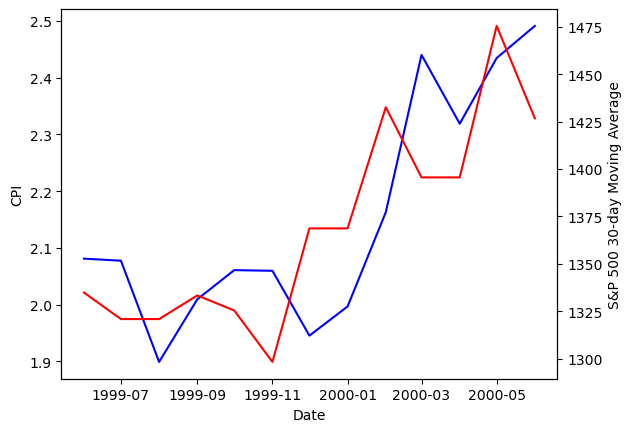

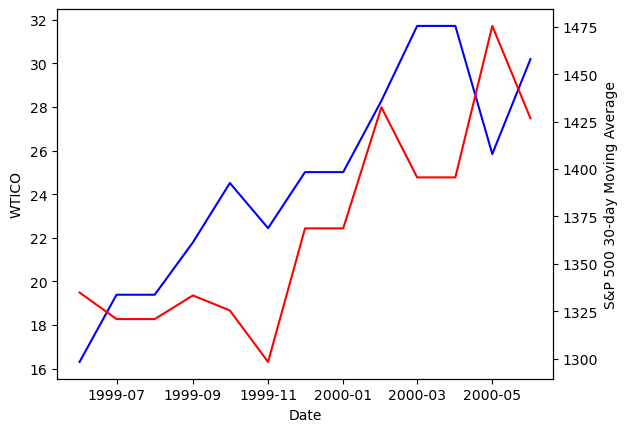

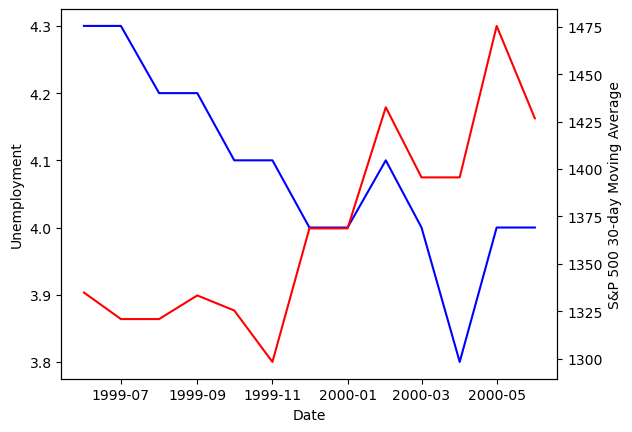

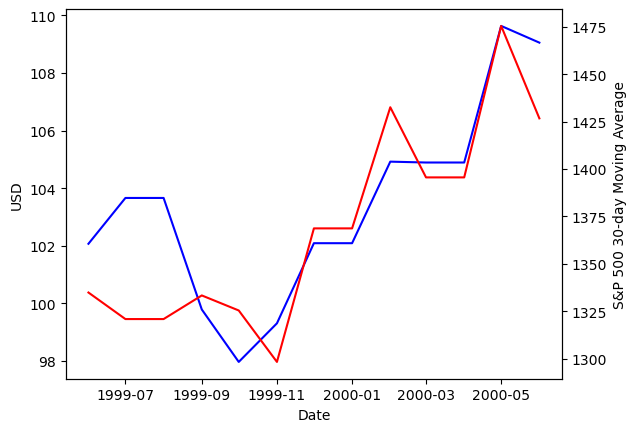

In [10]:
# Plot Dataset
List_Of_Variables = ['CPI', 'WTICO', 'Unemployment', 'USD']

# Loop through each variable and plot the graph
for i in List_Of_Variables:
    fig, ax1 = plt.subplots()
    ax1.plot(df_time_filtered1.index, df_time_filtered1[i], color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(i)
    ax2 = ax1.twinx()
    ax2.plot(df_time_filtered1.index, df_time_filtered1['sp500r30'], color='r') 
    ax2.set_ylabel('S&P 500 30-day Moving Average')
plt.show()

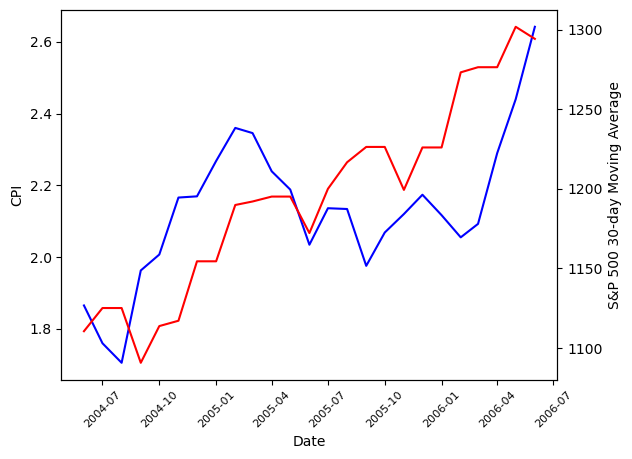

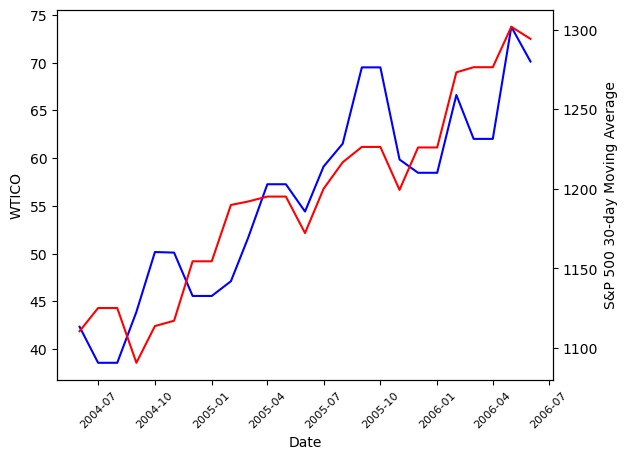

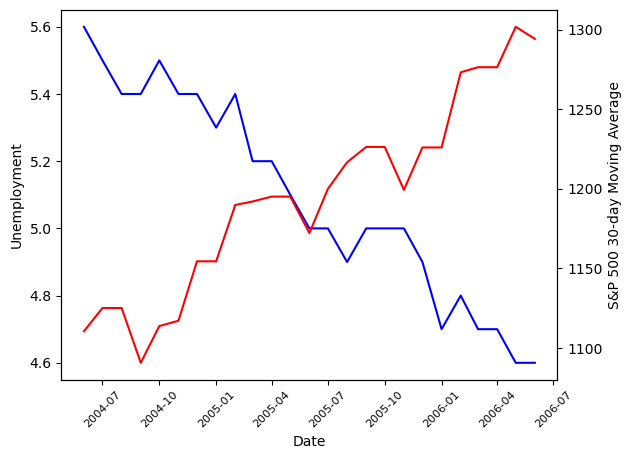

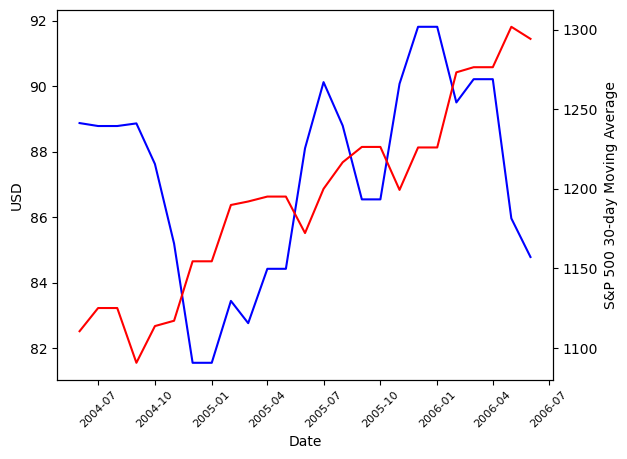

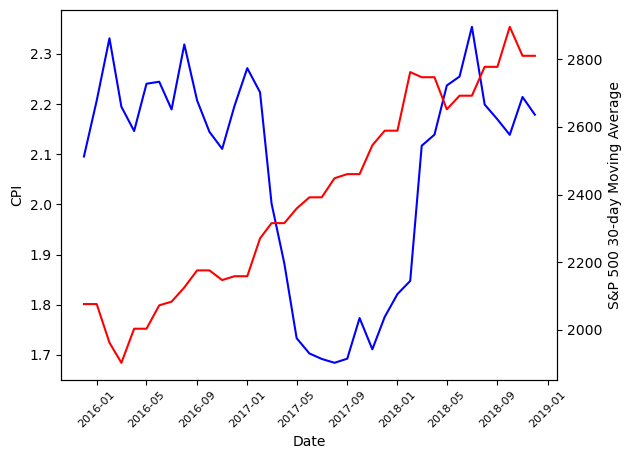

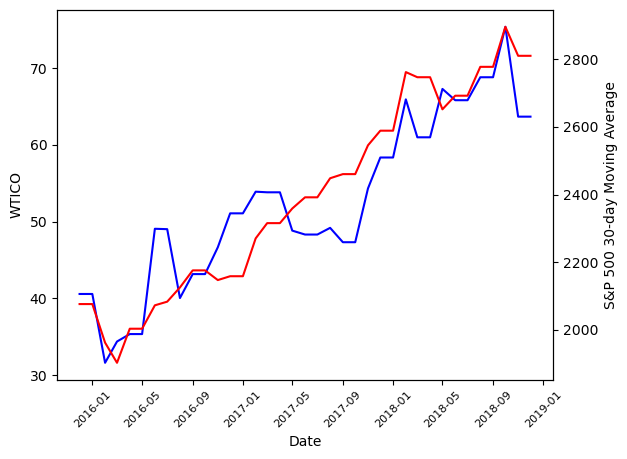

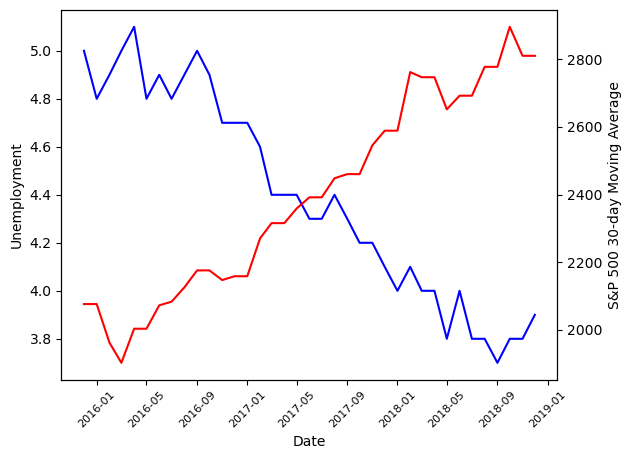

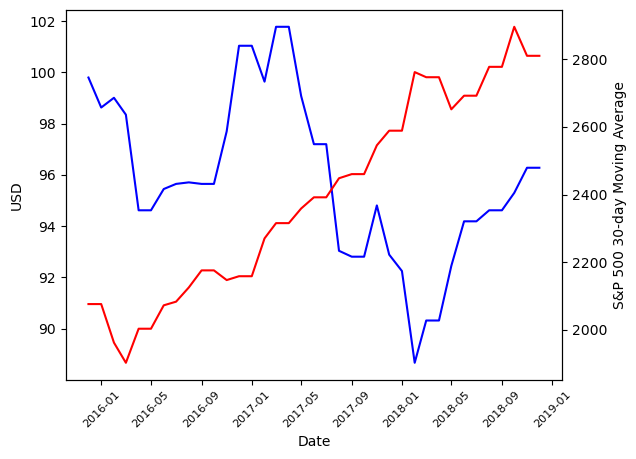

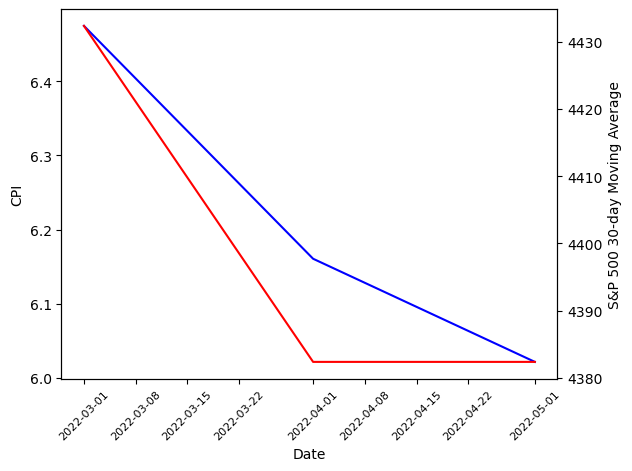

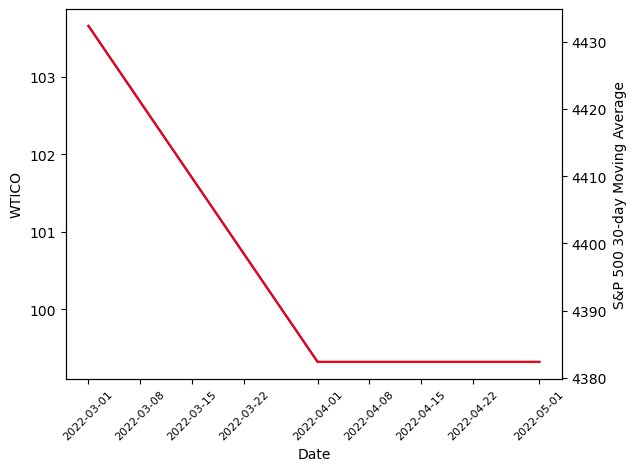

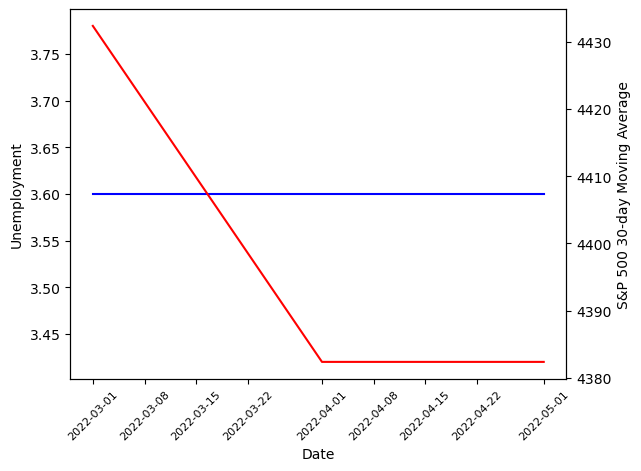

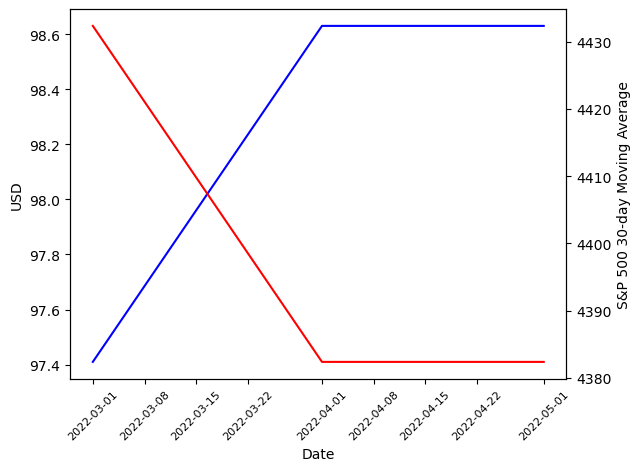

In [11]:
# We can definitely notice some positive correlation with CPI, WTI Crude Oil price, USD and S&P 500 30-day Moving Average from
#June 1999 to June 2000. Now let's look at other 3 time periods as well. 

# Define the time periods
time_periods = [
    {'start_date': '2004-06-01', 'end_date': '2006-06-01'},
    {'start_date': '2015-12-01', 'end_date': '2018-12-01'},
    {'start_date': '2022-03-01', 'end_date': '2022-12-01'}
]

List_Of_Variables = ['CPI', 'WTICO', 'Unemployment', 'USD']

# Loop through each time period and plot the graph for each variable
for tp in time_periods:
    # Filter the data for the current time period
    time_filter = (df.index >= tp['start_date']) & (df.index <= tp['end_date'])
    df_time_filtered = df[time_filter]

    # Loop through each variable and plot the graph
    for i in List_Of_Variables:
        fig, ax1 = plt.subplots()
        ax1.plot(df_time_filtered.index, df_time_filtered[i], color='b')
        ax1.set_xlabel('Date')
        ax1.set_ylabel(i)
        ax1.tick_params(axis='x', rotation=45, labelsize=8) # Rotate x-axis tick labels diagonally
        ax2 = ax1.twinx()
        ax2.plot(df_time_filtered.index, df_time_filtered['sp500r30'], color='r') 
        ax2.set_ylabel('S&P 500 30-day Moving Average')
    plt.show()

For all four time periods, we can notice a positive correlation between S&P 500 30-day Moving Average and three variables: CPI, WTICO, and USD. Unemployment seems to have a negative correlation with S&P 500 30-day Moving Average. Now that we have identified which variables tend to affect S&P 500 performance, let's combine all four time periods.

In [12]:
# As mentioned in the summary, we will be focusing specifically on time periods where the Fed has raised interest rates. 
# Since 1990, there have been four rate hiking cycles, lasting 18 months on average: June 1999 to June 2000, June 2004 to June 
# 2006, December 2015 to December 2018, March 2022 to current. 
df.index = pd.to_datetime(df.index)
time1 = (df.index >= '1999-06-01') & (df.index <= '2000-06-01')
time2 = (df.index >= '2004-06-01') & (df.index <= '2006-06-01')
time3 = (df.index >= '2015-12-01') & (df.index <= '2018-12-01')
time4 = (df.index >= '2022-03-01') & (df.index <= '2022-12-01')
df_time_filtered = df[time1 | time2 | time3 | time4]
df_time_filtered

,CPI,sp500r30,WTICO,Unemployment,USD
Date,,,,,
1999-06-01,2.080925,1334.848667,16.31,4.3,102.07
1999-07-01,2.077323,1320.843333,19.39,4.3,103.66
1999-08-01,1.898734,1320.843333,19.39,4.2,103.66
1999-09-01,2.009185,1333.316000,21.79,4.2,99.79
1999-10-01,2.060675,1325.375000,24.51,4.1,97.97
...,...,...,...,...,...
2018-11-01,2.214271,2810.153667,63.67,3.8,96.28
2018-12-01,2.178989,2810.153667,63.67,3.9,96.28
2022-03-01,6.474479,4432.361667,103.66,3.6,97.41


In [13]:
df_time_filtered.fillna(method='ffill', inplace=True)
print(df_time_filtered.isnull().sum())
df_time_filtered.describe()
#Using ffill had no significant impact on the standard deviation or mean of our datasets

CPI             0
sp500r30        0
WTICO           0
Unemployment    0
USD             0
dtype: int64


C:\Users\ijees\AppData\Local\Temp\ipykernel_33016\3365580892.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_filtered.fillna(method='ffill', inplace=True)


,CPI,sp500r30,WTICO,Unemployment,USD
count,78.000000,78.000000,78.000000,78.000000,78.000000
mean,2.261512,1916.579521,50.734744,4.534615,94.423974
std,0.823800,782.380491,17.728713,0.547919,6.444526
min,1.684402,1090.733333,16.310000,3.600000,81.560000
25%,2.003275,1237.987750,40.182500,4.025000,89.652500
50%,2.141977,1932.471167,50.130000,4.600000,94.620000
75%,2.240272,2434.113750,61.377500,5.000000,98.915000
max,6.474479,4432.361667,103.660000,5.600000,109.630000


                   CPI  sp500r30     WTICO  Unemployment       USD
CPI           1.000000  0.583229  0.566166     -0.329831  0.120495
sp500r30      0.583229  1.000000  0.581349     -0.643944  0.263296
WTICO         0.566166  0.581349  1.000000     -0.208131 -0.405099
Unemployment -0.329831 -0.643944 -0.208131      1.000000 -0.574759
USD           0.120495  0.263296 -0.405099     -0.574759  1.000000


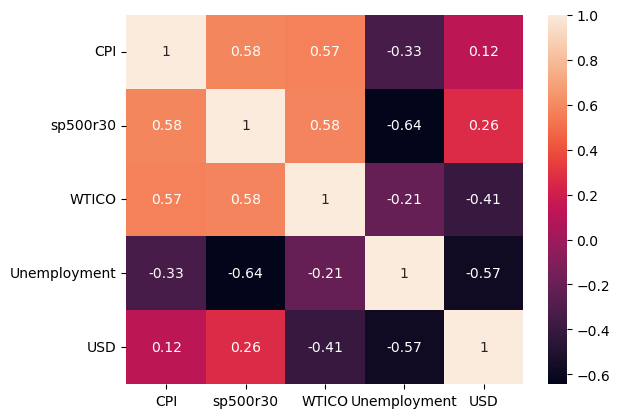

In [14]:
#Create a Heatmap
print(df_time_filtered.corr())
sns.heatmap(df_time_filtered.corr(), annot=True)
plt.show()

It seems like S&P 500 closed higher when CPI/Inflation numbers rose with high correlation of 0.9. WTI Crude Oil price and US Dollar index also showed a weak but positive correlation. Unemployment actually showed fairly strong negative correlation of -0.64. 

In [15]:
# Let's implement an Ordinary Least Squares regression model to predict the S&P 500 return using three independent variables. 
ind_var = pd.DataFrame(df_time_filtered, columns = ['CPI', 'WTICO', 'USD'])
dep_var = pd.DataFrame(df_time_filtered, columns = ['sp500r30'])

x = ind_var[['CPI', 'WTICO', 'USD']]
ind_var = sm.add_constant(ind_var)
y = dep_var['sp500r30']

regression_model = sm.OLS(y,x).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               sp500r30   R-squared (uncentered):                   0.923
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              300.3
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                    1.09e-41
Time:                        20:51:37   Log-Likelihood:                         -606.09
No. Observations:                  78   AIC:                                      1218.
Df Residuals:                      75   BIC:                                      1225.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CPI          300.2168    101.834      2.948      0.004      97.354     503.080
WTICO         15.6444      4.307      3.632      0.001       7.064      24.225
USD            4.8848      2.221      2.199      0.031       0.460       9.309
==============================================================================
Omnibus:                       71.674   Durbin-Watson:                   0.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.393
Skew:                          -0.242   Prob(JB):                       0.0248
Kurtosis:                       1.572   Cond. No.                         165.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the OLS Regression Results, the uncentered R-squared value is 0.923, indicating that the independent variables (CPI, WTICO, and USD) explain approximately 92.3% of the variation in the dependent variable (S&P 500 30-day Moving Average).

The F-statistic of 300.3 and associated p-value of 1.09e-41 suggest that the model is statistically significant, and that at least one of the independent variables has a non-zero effect on the dependent variable.

Looking at the coefficients for the independent variables, all three (CPI, WTICO, and USD) have a positive coefficient. This indicates that as these variables increase, the S&P 500 30-day Moving Average is likely to increase as well. The t-tests and associated p-values for the coefficients indicate that all three variables are statistically significant in predicting the dependent variable.

Overall, based on this OLS regression model, it appears that the CPI, WTICO, and USD are all statistically significant predictors of the S&P 500 30-day Moving Average. However, the model assumptions regarding normality of residuals and absence of autocorrelation may not be met, and these issues should be further explored and addressed if necessary.

C:\Users\ijees\AppData\Local\Temp\ipykernel_33016\349810435.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_filtered['Prediction'] = pd.DataFrame(regression_model.predict(x))


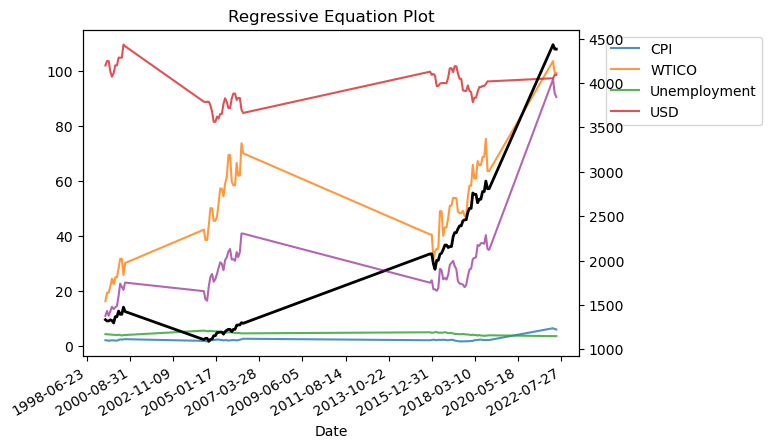

In [16]:
# Visualizing the relationship between the three independent variables and the dependent variable, S&P 500 30-day moving average. 
df_time_filtered['Prediction'] = pd.DataFrame(regression_model.predict(x))

first_axis = df_time_filtered['CPI'].plot(alpha = 0.8)
first_axis = df_time_filtered['WTICO'].plot(alpha = 0.8)
first_axis = df_time_filtered['Unemployment'].plot(alpha = 0.8)
first_axis = df_time_filtered['USD'].plot(alpha = 0.8)
first_axis.xaxis.set_major_locator(plt.MaxNLocator(15))

second_axis = first_axis.twinx()
second_axis.plot(df_time_filtered['sp500r30'], color='Black', linewidth=2, label='S&P500')
second_axis.plot(df_time_filtered['Prediction'], color='purple', alpha=0.6, label='Prediction')
second_axis.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title('Regressive Equation Plot')
first_axis.legend(bbox_to_anchor = (1.04,1), loc = "upper left")
plt.show()

# Part 2 
In above analysis, we used monthly data by taking S&P 500 30-day moving average to match other monthly data. We will now run the same analysis using daily data and fill any missing data for those with only monthly data using ffill. 

In [17]:
df = pd.merge(df_sp500, df_cpi_monthly, on='Date', how='left')
df = pd.merge(df, df_wti_co, on='Date', how='left')
df = pd.merge(df, df_unemployment, on='Date', how='left')
df = pd.merge(df, df_usd, on='Date', how='left')
df = df.rename(columns={'USACPICORMINMEI': 'CPI', 'DCOILWTICO': 'WTICO', 'Value': 'Unemployment', 'Price': 'USD'})
df.tail() # using .tail instead of .head since CPI and SP500 will return NaN for first 12 numbers

,Close,sp500r30,CPI,WTICO,Unemployment,USD
Date,,,,,,
1/5/2023,3808.10,3923.461667,NaN,NaN,NaN,NaN
1/6/2023,3895.08,3919.845000,NaN,NaN,NaN,NaN
1/9/2023,3892.09,3915.339333,NaN,NaN,NaN,NaN
1/10/2023,3919.25,3911.777000,NaN,NaN,NaN,NaN
1/11/2023,3969.61,3911.966000,NaN,NaN,NaN,NaN


In [18]:
print(df.isnull().sum())
df.describe()
df.fillna(method='ffill', inplace=True)
df.describe()

 Close             0
sp500r30          29
CPI             8317
WTICO             50
Unemployment    8319
USD              266
dtype: int64


,Close,sp500r30,CPI,WTICO,Unemployment,USD
count,8574.000000,8545.000000,8553.000000,8574.000000,8300.000000,8325.000000
mean,1469.994927,1467.917852,2.603117,48.664722,5.827614,91.566221
std,1004.879225,999.592828,1.154959,29.469725,1.739946,9.979050
min,275.310000,288.650667,0.610698,-36.980000,3.500000,71.330000
25%,811.890000,818.306333,1.909671,21.222500,4.500000,83.740000
50%,1230.260000,1227.949000,2.244650,42.570000,5.500000,91.130000
75%,1909.727500,1921.592000,2.894737,70.117500,6.900000,97.260000
max,4796.560000,4696.296333,6.474479,145.310000,14.700000,120.900000


In [19]:
df.index = pd.to_datetime(df.index)
time1 = (df.index >= '1999-06-01') & (df.index <= '2000-06-01')
df_time_filtered1 = df[time1]
df_time_filtered1

,Close,sp500r30,CPI,WTICO,Unemployment,USD
Date,,,,,,
1999-06-01,1294.26,1334.848667,2.080925,16.31,4.3,102.07
1999-06-02,1294.81,1334.470000,2.080925,16.61,4.3,102.79
1999-06-03,1299.54,1333.250667,2.080925,16.81,4.3,102.98
1999-06-04,1327.75,1332.215000,2.080925,17.36,4.3,102.65
1999-06-07,1334.52,1331.470667,2.080925,17.91,4.3,103.11
...,...,...,...,...,...,...
2000-05-25,1381.52,1425.775000,2.434881,30.43,4.0,110.75
2000-05-26,1378.02,1423.692000,2.434881,29.76,4.0,109.12
2000-05-30,1422.45,1425.888333,2.434881,30.36,4.0,108.93


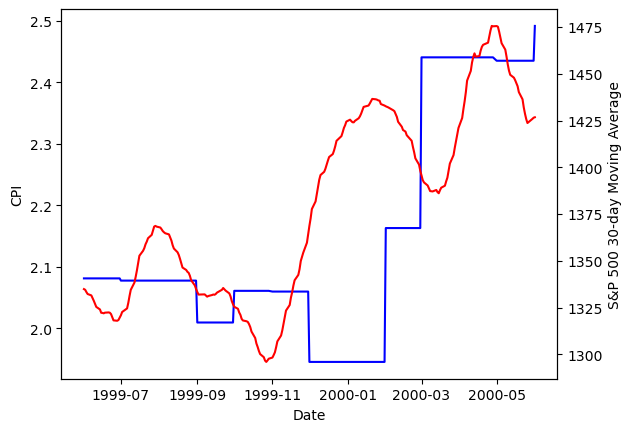

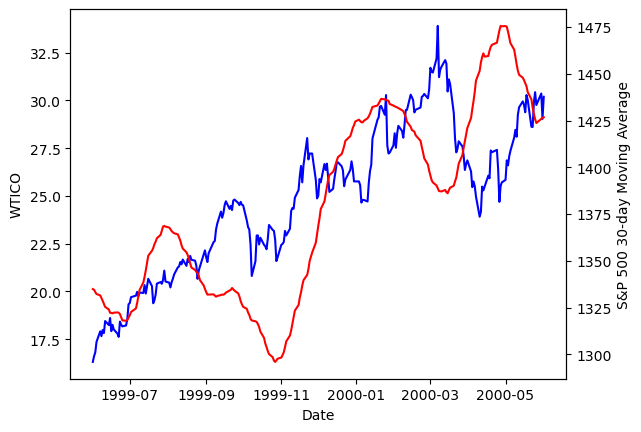

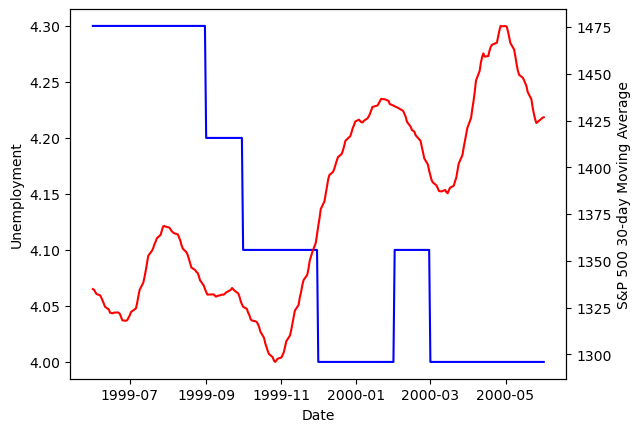

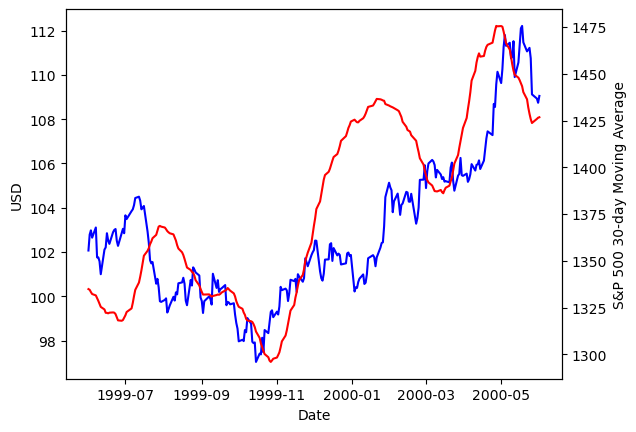

In [20]:
# Plot Dataset
List_Of_Variables = ['CPI', 'WTICO', 'Unemployment', 'USD']

# Loop through each variable and plot the graph
for i in List_Of_Variables:
    fig, ax1 = plt.subplots()
    ax1.plot(df_time_filtered1.index, df_time_filtered1[i], color='b')
    ax1.set_xlabel('Date')
    ax1.set_ylabel(i)
    ax2 = ax1.twinx()
    ax2.plot(df_time_filtered1.index, df_time_filtered1['sp500r30'], color='r') 
    ax2.set_ylabel('S&P 500 30-day Moving Average')
plt.show()

In [21]:
df.index = pd.to_datetime(df.index)
time1 = (df.index >= '1999-06-01') & (df.index <= '2000-06-01')
time2 = (df.index >= '2004-06-01') & (df.index <= '2006-06-01')
time3 = (df.index >= '2015-12-01') & (df.index <= '2018-12-01')
time4 = (df.index >= '2022-03-01') & (df.index <= '2022-12-01')
df_time_filtered = df[time1 | time2 | time3 | time4]
df_time_filtered

,Close,sp500r30,CPI,WTICO,Unemployment,USD
Date,,,,,,
1999-06-01,1294.26,1334.848667,2.080925,16.31,4.3,102.07
1999-06-02,1294.81,1334.470000,2.080925,16.61,4.3,102.79
1999-06-03,1299.54,1333.250667,2.080925,16.81,4.3,102.98
1999-06-04,1327.75,1332.215000,2.080925,17.36,4.3,102.65
1999-06-07,1334.52,1331.470667,2.080925,17.91,4.3,103.11
...,...,...,...,...,...,...
2022-11-25,4026.12,3847.588667,6.160574,76.45,3.6,105.96
2022-11-28,3963.94,3860.284333,6.160574,77.10,3.6,106.68
2022-11-29,3957.63,3869.607000,6.160574,77.96,3.6,106.82


In [22]:
# Ordinary Least Squares regression model
ind_var = pd.DataFrame(df_time_filtered, columns = ['CPI', 'WTICO', 'USD'])
dep_var = pd.DataFrame(df_time_filtered, columns = ['sp500r30'])

x = ind_var[['CPI', 'WTICO', 'USD']]
ind_var = sm.add_constant(ind_var)
y = dep_var['sp500r30']

regression_model = sm.OLS(y,x).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               sp500r30   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              9321.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        20:51:38   Log-Likelihood:                         -13194.
No. Observations:                1709   AIC:                                  2.639e+04
Df Residuals:                    1706   BIC:                                  2.641e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
CPI          297.3873     15.051     19.758      0.000     267.867     326.908
WTICO         15.8298      0.865     18.298      0.000      14.133      17.527
USD            5.0220      0.383     13.104      0.000       4.270       5.774
==============================================================================
Omnibus:                     5710.726   Durbin-Watson:                   0.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              139.843
Skew:                          -0.247   Prob(JB):                     4.30e-31
Kurtosis:                       1.689   Cond. No.                         126.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The second OLS regression model is more significant as it has a higher R-squared value of 0.942 compared to the first model with an R-squared value of 0.923. The F-statistic for the second model is also much higher at 9321 with a probability of 0.00, indicating strong evidence that at least one of the independent variables is related to the dependent variable.

Additionally, the standard errors for the coefficients in the second model are smaller than those in the first model, which suggests that the estimates of the coefficients are more precise. Finally, the p-values for all the independent variables in the second model are very low, indicating that they are statistically significant predictors of the dependent variable.

C:\Users\ijees\AppData\Local\Temp\ipykernel_33016\3898438784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_filtered['Prediction'] = pd.DataFrame(regression_model.predict(x))


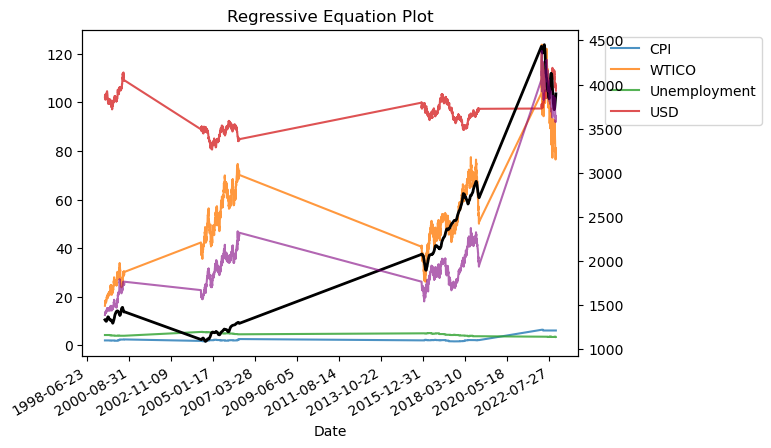

In [23]:
df_time_filtered['Prediction'] = pd.DataFrame(regression_model.predict(x))

first_axis = df_time_filtered['CPI'].plot(alpha = 0.8)
first_axis = df_time_filtered['WTICO'].plot(alpha = 0.8)
first_axis = df_time_filtered['Unemployment'].plot(alpha = 0.8)
first_axis = df_time_filtered['USD'].plot(alpha = 0.8)
first_axis.xaxis.set_major_locator(plt.MaxNLocator(15))

second_axis = first_axis.twinx()
second_axis.plot(df_time_filtered['sp500r30'], color='Black', linewidth=2, label='S&P500')
second_axis.plot(df_time_filtered['Prediction'], color='purple', alpha=0.6, label='Prediction')
second_axis.xaxis.set_major_locator(plt.MaxNLocator(15))
plt.title('Regressive Equation Plot')
first_axis.legend(bbox_to_anchor = (1.04,1), loc = "upper left")
plt.show()

**Conclusion.**
During the rising rate environment where Fed is raising interest rate, stock market tend to close the month higher than the preivous month. The exploration conducted did not reveal a clear relationship between inflation-related economic factors and the stock market during a rising rate environment. However, it is important to note that this study serves as a stepping stone for further exploration of historical data. Understanding the historical trends of the stock market can provide valuable insight into current market conditions and potential future developments. It is essential to continue to analyze historical data in order to gain a comprehensive understanding of the stock market and its relationship with inflation-related economic factors.

If you are curious about how the stock market performend during the rising rate environment, please check out my Tableau exploration:https://public.tableau.com/views/Capstone1_16607092350810/Story1?:language=en-US&:display_count=n&:origin=viz_share_link